# Phase 2 - RoBERTa Baseline

### **Overview**
*   **Goal of this notebook:** Implement and run baseline experiments for Sentiment Analysis and Sarcasm Detection using a fine-tuned RoBERTa model across multiple English varieties.
*   **Dataset + Evaluation Protocol:**
    *   **Tasks:** Sentiment Analysis, Sarcasm Detection.
    *   **Varieties:** Standard (US, UK) and Non-Standard (e.g., Australian, Indian).
    *   **Sources:** Google Reviews, Reddit.
    *   **Protocol:** Train on specific settings (Source/Variety), evaluate on in-domain, cross-domain, and cross-variety test sets.
*   **What this notebook runs:**
    1.  Setup (Install, Mount Drive, Config).
    2.  Data Loading (Index CSVs).
    3.  Model Definition (RoBERTa Binary Classifier).
    4.  Training & Evaluation Loop (for all defined settings).
    5.  Visualization (Heatmaps, Bar Charts).
    6.  Error Analysis.
*   **Outputs saved:**
    *   **Metrics:** `metrics/*.csv`
    *   **Predictions:** `predictions/*.csv`
    *   **Figures:** `figures/*.png`
    *   **Checkpoints:** `checkpoints/*.pt`
*   **How to reproduce:**
    *   **Seed:** Set to `42` in Step 4.
    *   **Config:** Hyperparameters defined in `CFG` (Step 3).
    *   **Model:** Uses `roberta-base` by default.

### **Step 1 — Setup Environment**
*   **Purpose:** Install required Python libraries for the project.
*   **Main Inputs:** `transformers`, `accelerate`, `datasets`, `scikit-learn` packages.
*   **Main Outputs:** Installed environment.

In [ ]:
!pip -q install -U transformers accelerate datasets scikit-learn

import os, re, json, math, random, time
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)

from torch.optim import AdamW

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 55.2 MB/s eta 0:00:00


### **Step 2 — Mount Google Drive**
*   **Purpose:** Connect to Google Drive to access datasets and save model artifacts.
*   **Main Inputs:** User authentication.
*   **Main Outputs:** Mounted drive at `/content/drive`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Step 3 — Configuration & Directories**
*   **Purpose:** Define file paths and configuration dictionary (`CFG`).
*   **Main Inputs:** Base path `/content/drive/MyDrive/DNLP`.
*   **Main Outputs:** Created directories (`CKPT_DIR`, `MET_DIR`, etc.) and `CFG` dict.
*   **Assumptions:** Dataset is located in `data/processed` under the base path.

### **Step 4 — Reproducibility**
*   **Purpose:** Set random seeds for Python, NumPy, and PyTorch.
*   **Main Inputs:** `CFG["SEED"]` (default: 42).
*   **Main Outputs:** Deterministic environment state.

In [ ]:
BASE = Path("/content/drive/MyDrive/DNLP")

PROC_DIR = BASE / "data" / "processed"
RUN_DIR  = BASE / "models" / "roberta_baseline_ce"   # change if you want

CKPT_DIR = RUN_DIR / "checkpoints"
MET_DIR  = RUN_DIR / "metrics"
PRD_DIR  = RUN_DIR / "predictions"
FIG_DIR  = RUN_DIR / "figures"

for d in [CKPT_DIR, MET_DIR, PRD_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

CFG = {
    "SEED": 42,
    "MODEL_NAME": "roberta-base",
    "MAX_LEN": 256,            # keep 256 for baseline speed; extension can use 512
    "BATCH_SIZE": 16,
    "LR": 2e-5,
    "WD": 0.01,
    "EPOCHS": 5,
    "PATIENCE": 2,
    "WARMUP_RATIO": 0.1,
    "GRAD_CLIP": 1.0,
    "USE_AMP": True,
    "NUM_WORKERS": 2,
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)
print("PROC_DIR:", PROC_DIR)
print("RUN_DIR :", RUN_DIR)

DEVICE: cuda
PROC_DIR: /content/drive/MyDrive/DNLP/data/processed
RUN_DIR : /content/drive/MyDrive/DNLP/models/roberta_baseline_ce


In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG["SEED"])

### **Step 5 — Load Data Indices**
*   **Purpose:** Load the CSV index files that define training settings and test sets.
*   **Main Inputs:** `index_settings.csv` and `index_testsets.csv`.
*   **Main Outputs:** DataFrames (`sent_settings`, `sarc_settings`, etc.).

In [ ]:
def load_index_settings(proc_dir: Path, task: str) -> pd.DataFrame:
    p = proc_dir / task / "index_settings.csv"
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p}")
    df = pd.read_csv(p)
    # expected columns: train_setting, train_csv, val_csv, ...
    return df

def load_testsets_index(proc_dir: Path, task: str) -> pd.DataFrame:
    p = proc_dir / task / "testsets" / "index_testsets.csv"
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p}")
    df = pd.read_csv(p)
    # expected columns: test_setting, test_csv, ...
    return df

sent_settings = load_index_settings(PROC_DIR, "sentiment")
sarc_settings = load_index_settings(PROC_DIR, "sarcasm")

sent_tests = load_testsets_index(PROC_DIR, "sentiment")
sarc_tests = load_testsets_index(PROC_DIR, "sarcasm")

print("Sentiment settings:", len(sent_settings), "| testsets:", len(sent_tests))
print("Sarcasm   settings:", len(sarc_settings), "| testsets:", len(sarc_tests))
display(sent_settings.head(5))
display(sent_tests.head(5))

Sentiment settings: 5 | testsets: 6
Sarcasm   settings: 4 | testsets: 5


,task,setting,train_csv,val_csv,splits_json,testsets_index_csv,n_train,n_val
0,sentiment,Google,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/splits/sentim...,/content/drive/MyDrive/DNLP/data/processed/sen...,3529,882
1,sentiment,Reddit,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/splits/sentim...,/content/drive/MyDrive/DNLP/data/processed/sen...,3564,891
2,sentiment,TRAIN_en-AU,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/splits/sentim...,/content/drive/MyDrive/DNLP/data/processed/sen...,2167,542
3,sentiment,TRAIN_en-IN,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/splits/sentim...,/content/drive/MyDrive/DNLP/data/processed/sen...,2667,666
4,sentiment,TRAIN_en-UK,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/splits/sentim...,/content/drive/MyDrive/DNLP/data/processed/sen...,2259,565


,test_setting,csv,n,label_counts,variety_counts,source_counts
0,TEST_FULL,/content/drive/MyDrive/DNLP/data/processed/sen...,1212,"{0: 611, 1: 601}","{'en-IN': 455, 'en-UK': 386, 'en-AU': 371}","{'Reddit': 609, 'Google': 603}"
1,TEST_Google,/content/drive/MyDrive/DNLP/data/processed/sen...,603,"{1: 450, 0: 153}","{'en-UK': 248, 'en-IN': 225, 'en-AU': 130}",{'Google': 603}
2,TEST_Reddit,/content/drive/MyDrive/DNLP/data/processed/sen...,609,"{0: 458, 1: 151}","{'en-AU': 241, 'en-IN': 230, 'en-UK': 138}",{'Reddit': 609}
3,TEST_en-AU,/content/drive/MyDrive/DNLP/data/processed/sen...,371,"{0: 198, 1: 173}",{'en-AU': 371},"{'Reddit': 241, 'Google': 130}"
4,TEST_en-IN,/content/drive/MyDrive/DNLP/data/processed/sen...,455,"{0: 229, 1: 226}",{'en-IN': 455},"{'Reddit': 230, 'Google': 225}"


### **Step 6 — Inspect Test Index**
*   **Purpose:** Verify the loaded test index by checking column names and a sample file path.
*   **Main Inputs:** `sarc_tests` DataFrame.
*   **Main Outputs:** Printed inspection info (columns, sample path).

In [ ]:
def _detect_path_col(df: pd.DataFrame, prefer_prefix="test"):
    cols = list(df.columns)

    # Most common candidates, in priority order
    preferred = [
        f"{prefer_prefix}_csv", f"{prefer_prefix}_path",
        "test_csv", "test_path", "csv_path", "path", "file", "filepath"
    ]
    for c in preferred:
        if c in cols:
            return c

    # fallback: any column that looks like it contains csv paths
    for c in cols:
        if df[c].astype(str).str.contains(r"\.csv$", case=False, na=False).any():
            return c

    raise KeyError(f"Couldn't detect a CSV path column in test index. Columns are: {cols}")

print("sarc_tests columns:", list(sarc_tests.columns))

path_col = _detect_path_col(sarc_tests, prefer_prefix="test")
print("Detected test CSV path column:", path_col)

tmp_path = sarc_tests.iloc[0][path_col]
print("Example test csv path:", tmp_path)

tmp = pd.read_csv(tmp_path)
if "source_name" in tmp.columns:
    print("Sarcasm sample sources:", tmp["source_name"].unique())
else:
    print("No source_name column found in the test CSV. Columns:", list(tmp.columns))

sarc_tests columns: ['test_setting', 'csv', 'n', 'label_counts', 'variety_counts', 'source_counts']
Detected test CSV path column: csv
Example test csv path: /content/drive/MyDrive/DNLP/data/processed/sarcasm/testsets/TEST_FULL.csv
Sarcasm sample sources: ['Reddit']


### **Step 7 — Load Tokenizer**
*   **Purpose:** Initialize the tokenizer for the pre-trained model.
*   **Main Inputs:** `CFG["MODEL_NAME"]` (roberta-base).
*   **Main Outputs:** `tokenizer` object.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(CFG["MODEL_NAME"], use_fast=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### **Step 8 — Dataset Class**
*   **Purpose:** Define the PyTorch Dataset class (`TextClsDataset`) and batch collator.
*   **Main Inputs:** DataFrames with `text` and `label` columns.
*   **Main Outputs:** Dataset class and `collate_fn`.

In [ ]:
TEXT_COL   = "text"
LABEL_COL  = "label"
TASK_COL   = "task"
VAR_COL    = "variety_name"
SRC_COL    = "source_name"

class TextClsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, max_len: int):
        self.df = df.reset_index(drop=True)
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        text = str(row[TEXT_COL])
        y = int(row[LABEL_COL])
        meta = {
            "variety_name": row.get(VAR_COL, ""),
            "source_name": row.get(SRC_COL, ""),
        }
        return text, y, meta

def collate_fn(batch):
    texts, ys, metas = zip(*batch)
    enc = tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=CFG["MAX_LEN"],
        return_tensors="pt"
    )
    y = torch.tensor(ys, dtype=torch.long)
    return enc, y, metas, list(texts)

### **Step 9 — Model Architecture**
*   **Purpose:** Define the binary classification model wrapping RoBERTa.
*   **Main Inputs:** `roberta-base` pre-trained weights.
*   **Main Outputs:** `RobertaBinary` PyTorch module.

In [ ]:
class RobertaBinary(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.back = AutoModel.from_pretrained(model_name)
        hid = self.back.config.hidden_size
        self.drop = nn.Dropout(0.1)
        self.cls = nn.Linear(hid, 2)

    def forward(self, input_ids, attention_mask):
        out = self.back(input_ids=input_ids, attention_mask=attention_mask)
        # RoBERTa has no pooler; use <s> token representation
        x = out.last_hidden_state[:, 0, :]
        x = self.drop(x)
        logits = self.cls(x)
        return logits

### **Step 10 — Metrics & Prediction**
*   **Purpose:** Define helper functions to calculate metrics (F1, Accuracy) and generate predictions.
*   **Main Inputs:** Model outputs (logits) and ground truth.
*   **Main Outputs:** Metrics dictionary and prediction DataFrame.

In [ ]:
def compute_metrics(y_true, y_pred):
    return {
        "acc": float(accuracy_score(y_true, y_pred)),
        "macro_f1": float(f1_score(y_true, y_pred, average="macro")),
        "precision": float(precision_score(y_true, y_pred, average="binary", zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, average="binary", zero_division=0)),
    }

@torch.no_grad()
def predict_df(model, loader):
    model.eval()
    rows = []
    for enc, y, metas, texts in loader:
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        logits = model(enc["input_ids"], enc["attention_mask"])
        prob = torch.softmax(logits, dim=-1)[:, 1].detach().cpu().numpy()
        pred = (prob >= 0.5).astype(int)
        y_np = y.numpy()

        for i in range(len(texts)):
            rows.append({
                "label": int(y_np[i]),
                "pred": int(pred[i]),
                "prob1": float(prob[i]),
                "variety_name": metas[i].get("variety_name", ""),
                "source_name": metas[i].get("source_name", ""),
                "text": texts[i],
            })
    return pd.DataFrame(rows)

### **Step 11 — Training Loop**
*   **Purpose:** Function to train the model for a single setting.
*   **Main Inputs:** Train/Val CSV paths, hyperparameters.
*   **Main Outputs:** Saved model checkpoint (`.pt`).
*   **Assumptions:** Uses class-weighted Cross-Entropy loss.

In [ ]:
def train_one_setting(task: str, train_setting: str, train_csv: str, val_csv: str,
                      lr=2e-5, wd=0.01, epochs=5, patience=2,
                      warmup_ratio=0.1, grad_clip=1.0, use_amp=True):

    # Define path once (variant is hardcoded to 'ce' here)
    ckpt_path = os.path.join(CKPT_DIR, f"{task}_{train_setting}_ce.pt")

    df_tr = pd.read_csv(train_csv)
    df_va = pd.read_csv(val_csv)

    tr_ds = TextClsDataset(df_tr, CFG["MAX_LEN"])
    va_ds = TextClsDataset(df_va, CFG["MAX_LEN"])

    tr_ld = DataLoader(tr_ds, batch_size=CFG["BATCH_SIZE"], shuffle=True,
                       num_workers=CFG["NUM_WORKERS"], collate_fn=collate_fn)
    va_ld = DataLoader(va_ds, batch_size=CFG["BATCH_SIZE"], shuffle=False,
                       num_workers=CFG["NUM_WORKERS"], collate_fn=collate_fn)

    model = RobertaBinary(CFG["MODEL_NAME"]).to(DEVICE)

    # class weights from train only
    y_tr = df_tr[LABEL_COL].values
    counts = np.bincount(y_tr, minlength=2).astype(np.float32)
    w = (counts.sum() / np.maximum(counts, 1.0))
    w = w / w.sum() * 2.0
    w_t = torch.tensor(w, dtype=torch.float32, device=DEVICE)

    crit = nn.CrossEntropyLoss(weight=w_t)
    opt = AdamW(model.parameters(), lr=lr, weight_decay=wd)

    total_steps = epochs * len(tr_ld)
    warmup_steps = int(total_steps * warmup_ratio)
    sch = get_linear_schedule_with_warmup(opt, warmup_steps, total_steps)

    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))

    best_f1 = -1
    best_state = None
    bad = 0

    for ep in range(1, epochs+1):
        model.train()
        losses = []
        for enc, y, metas, texts in tr_ld:
            enc = {k: v.to(DEVICE) for k, v in enc.items()}
            y = y.to(DEVICE)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type="cuda", enabled=(use_amp and DEVICE=="cuda")):
                logits = model(enc["input_ids"], enc["attention_mask"])
                loss = crit(logits, y)

            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(opt)
            scaler.update()
            sch.step()
            losses.append(loss.item())

        # val
        dfp = predict_df(model, va_ld)
        met = compute_metrics(dfp["label"].values, dfp["pred"].values)
        print(f"[{task} | {train_setting}] EP{ep} loss={np.mean(losses):.4f} val_macro_f1={met['macro_f1']:.4f}")

        if met["macro_f1"] > best_f1:
            best_f1 = met["macro_f1"]
            bad = 0
            # Save best state to memory (CPU) to persist it
            best_state = {k: v.clone().cpu() for k, v in model.state_dict().items()}
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping.")
                break

    # after training loop ends (no matter how it ends)
    assert best_state is not None, "best_state was never set (did training fail?)"
    torch.save(best_state, ckpt_path)
    print("✅ Saved:", ckpt_path)

    return str(ckpt_path)

### **Step 12 — Evaluation Loop**
*   **Purpose:** Function to evaluate a trained checkpoint on multiple test sets.
*   **Main Inputs:** Checkpoint path, Test Index DataFrame.
*   **Main Outputs:** Metrics DataFrame and Predictions DataFrame.

In [ ]:
def eval_on_testsets(task: str, train_setting: str, ckpt_path: str, test_index: pd.DataFrame):
    model = RobertaBinary(CFG["MODEL_NAME"]).to(DEVICE)
    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    model.eval()

    all_metrics = []
    all_preds = []

    for _, row in test_index.iterrows():
        test_setting = row["test_setting"]
        test_csv = row["test_csv"]

        df_te = pd.read_csv(test_csv)
        te_ds = TextClsDataset(df_te, CFG["MAX_LEN"])
        te_ld = DataLoader(te_ds, batch_size=CFG["BATCH_SIZE"], shuffle=False,
                           num_workers=CFG["NUM_WORKERS"], collate_fn=collate_fn)

        dfp = predict_df(model, te_ld)
        met = compute_metrics(dfp["label"].values, dfp["pred"].values)

        met_row = {
            "task": task,
            "train_setting": train_setting,
            "variant": "ce",
            "test_setting": test_setting,
            "split": "test",
            "n": int(len(dfp)),
            **met
        }
        all_metrics.append(met_row)

        # add metadata for saving
        dfp.insert(0, "task", task)
        dfp.insert(1, "variant", "ce")
        dfp.insert(2, "train_setting", train_setting)
        dfp.insert(3, "test_setting", test_setting)

        all_preds.append(dfp)

        # per-variety breakdown for TEST_* (especially cross-variety)
        if "variety_name" in dfp.columns:
            pv = []
            for g, dfg in dfp.groupby("variety_name"):
                m = compute_metrics(dfg["label"].values, dfg["pred"].values)
                pv.append({
                    "task": task,
                    "train_setting": train_setting,
                    "variant": "ce",
                    "test_setting": test_setting,
                    "group": g,
                    "n": int(len(dfg)),
                    **m
                })
            pv = pd.DataFrame(pv)
            pv_path = MET_DIR / f"pervar_{task}_{train_setting}_{test_setting}_ce.csv"
            pv.to_csv(pv_path, index=False)

    met_df = pd.DataFrame(all_metrics)
    pred_df = pd.concat(all_preds, ignore_index=True)

    return met_df, pred_df

### **Step 13 — Main Execution**
*   **Purpose:** Orchestrate the training and evaluation for Sentiment and Sarcasm tasks.
*   **Main Inputs:** Settings DataFrames (`sent_settings`, `sarc_settings`).
*   **Main Outputs:** Consolidated `metrics_all.csv` and `predictions_all.csv`.

In [ ]:
def run_task(task: str, settings_df: pd.DataFrame, test_df: pd.DataFrame, limit_settings=None):
    # Pre-process DataFrames to match expected column names
    # Settings: expect 'train_setting', have 'setting'
    if "train_setting" not in settings_df.columns and "setting" in settings_df.columns:
        settings_df = settings_df.rename(columns={"setting": "train_setting"})

    # Tests: expect 'test_csv', have 'csv'
    if "test_csv" not in test_df.columns and "csv" in test_df.columns:
        test_df = test_df.rename(columns={"csv": "test_csv"})

    # Optionally limit which settings to run (smoke test)
    df = settings_df.copy()
    if limit_settings is not None:
        df = df[df["train_setting"].isin(limit_settings)].copy()

    all_met = []
    all_pred = []

    print(f"\n=== RUN TASK: {task} | settings: {len(df)} | testsets: {len(test_df)} ===")

    for _, r in df.iterrows():
        train_setting = r["train_setting"]
        train_csv = r["train_csv"]
        val_csv = r["val_csv"]

        ckpt = train_one_setting(
            task=task,
            train_setting=train_setting,
            train_csv=train_csv,
            val_csv=val_csv,
            lr=CFG["LR"], wd=CFG["WD"], epochs=CFG["EPOCHS"], patience=CFG["PATIENCE"],
            warmup_ratio=CFG["WARMUP_RATIO"], grad_clip=CFG["GRAD_CLIP"], use_amp=CFG["USE_AMP"]
        )

        # Handle Drive sync latency
        if not os.path.exists(ckpt):
            print(f"Waiting for checkpoint sync: {ckpt}")
            time.sleep(3)

        if not os.path.exists(ckpt):
            print(f"Warning: Checkpoint still not found: {ckpt}. Skipping evaluation.")
            continue

        met_df, pred_df = eval_on_testsets(task, train_setting, ckpt, test_df)

        # save per-setting predictions
        pred_path = PRD_DIR / f"{task}_{train_setting}_ce_preds.csv"
        pred_df.to_csv(pred_path, index=False)

        all_met.append(met_df)
        all_pred.append(pred_df)

    if len(all_met) == 0:
        return pd.DataFrame(), pd.DataFrame()

    all_met = pd.concat(all_met, ignore_index=True)
    all_pred = pd.concat(all_pred, ignore_index=True)
    return all_met, all_pred


# Sarcasm is Reddit-only protocol; your preprocess already ensures that settings/testsets reflect that. :contentReference[oaicite:2]{index=2}
sent_met, sent_pred = run_task("sentiment", sent_settings, sent_tests, limit_settings=None)
sarc_met, sarc_pred = run_task("sarcasm", sarc_settings, sarc_tests, limit_settings=None)

metrics_all = pd.concat([sent_met, sarc_met], ignore_index=True) if len(sent_met)+len(sarc_met) else pd.DataFrame()
preds_all   = pd.concat([sent_pred, sarc_pred], ignore_index=True) if len(sent_pred)+len(sarc_pred) else pd.DataFrame()

metrics_path = MET_DIR / "roberta_ce_metrics_all.csv"
preds_path   = PRD_DIR / "roberta_ce_predictions_all.csv"

metrics_all.to_csv(metrics_path, index=False)
preds_all.to_csv(preds_path, index=False)

print("Saved:", metrics_path)
print("Saved:", preds_path)
display(metrics_all.head(20))


=== RUN TASK: sentiment | settings: 5 | testsets: 6 ===


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-891748312.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sentiment | Google] EP1 loss=0.4625 val_macro_f1=0.8234
[sentiment | Google] EP2 loss=0.2802 val_macro_f1=0.8944
[sentiment | Google] EP3 loss=0.1697 val_macro_f1=0.8989
[sentiment | Google] EP4 loss=0.1082 val_macro_f1=0.9062
[sentiment | Google] EP5 loss=0.0743 val_macro_f1=0.9075
✅ Saved: /content/drive/MyDrive/DNLP/models/roberta_baseline_ce/checkpoints/sentiment_Google_ce.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-891748312.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sentiment | Reddit] EP1 loss=0.5548 val_macro_f1=0.8198
[sentiment | Reddit] EP2 loss=0.3520 val_macro_f1=0.8336
[sentiment | Reddit] EP3 loss=0.2530 val_macro_f1=0.8156
[sentiment | Reddit] EP4 loss=0.1735 val_macro_f1=0.8280
Early stopping.
✅ Saved: /content/drive/MyDrive/DNLP/models/roberta_baseline_ce/checkpoints/sentiment_Reddit_ce.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-891748312.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sentiment | TRAIN_en-AU] EP1 loss=0.4884 val_macro_f1=0.8929
[sentiment | TRAIN_en-AU] EP2 loss=0.2469 val_macro_f1=0.9122
[sentiment | TRAIN_en-AU] EP3 loss=0.1845 val_macro_f1=0.9141
[sentiment | TRAIN_en-AU] EP4 loss=0.1165 val_macro_f1=0.9174
[sentiment | TRAIN_en-AU] EP5 loss=0.0576 val_macro_f1=0.9200
✅ Saved: /content/drive/MyDrive/DNLP/models/roberta_baseline_ce/checkpoints/sentiment_TRAIN_en-AU_ce.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-891748312.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sentiment | TRAIN_en-IN] EP1 loss=0.5230 val_macro_f1=0.8602
[sentiment | TRAIN_en-IN] EP2 loss=0.3347 val_macro_f1=0.8527
[sentiment | TRAIN_en-IN] EP3 loss=0.2368 val_macro_f1=0.8513
Early stopping.
✅ Saved: /content/drive/MyDrive/DNLP/models/roberta_baseline_ce/checkpoints/sentiment_TRAIN_en-IN_ce.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-891748312.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sentiment | TRAIN_en-UK] EP1 loss=0.4054 val_macro_f1=0.9469
[sentiment | TRAIN_en-UK] EP2 loss=0.1645 val_macro_f1=0.9538
[sentiment | TRAIN_en-UK] EP3 loss=0.0788 val_macro_f1=0.9628
[sentiment | TRAIN_en-UK] EP4 loss=0.0488 val_macro_f1=0.9734
[sentiment | TRAIN_en-UK] EP5 loss=0.0220 val_macro_f1=0.9716
✅ Saved: /content/drive/MyDrive/DNLP/models/roberta_baseline_ce/checkpoints/sentiment_TRAIN_en-UK_ce.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== RUN TASK: sarcasm | settings: 4 | testsets: 5 ===


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-891748312.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sarcasm | FULL] EP1 loss=0.6958 val_macro_f1=0.6375
[sarcasm | FULL] EP2 loss=0.6012 val_macro_f1=0.6618
[sarcasm | FULL] EP3 loss=0.4346 val_macro_f1=0.6488
[sarcasm | FULL] EP4 loss=0.3029 val_macro_f1=0.6810
[sarcasm | FULL] EP5 loss=0.2001 val_macro_f1=0.6756
✅ Saved: /content/drive/MyDrive/DNLP/models/roberta_baseline_ce/checkpoints/sarcasm_FULL_ce.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-891748312.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sarcasm | TRAIN_en-AU] EP1 loss=0.6748 val_macro_f1=0.6949
[sarcasm | TRAIN_en-AU] EP2 loss=0.5000 val_macro_f1=0.7149
[sarcasm | TRAIN_en-AU] EP3 loss=0.3617 val_macro_f1=0.7029
[sarcasm | TRAIN_en-AU] EP4 loss=0.2241 val_macro_f1=0.7270
[sarcasm | TRAIN_en-AU] EP5 loss=0.1366 val_macro_f1=0.6857
✅ Saved: /content/drive/MyDrive/DNLP/models/roberta_baseline_ce/checkpoints/sarcasm_TRAIN_en-AU_ce.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-891748312.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sarcasm | TRAIN_en-IN] EP1 loss=0.6877 val_macro_f1=0.5184
[sarcasm | TRAIN_en-IN] EP2 loss=0.6020 val_macro_f1=0.5607
[sarcasm | TRAIN_en-IN] EP3 loss=0.5101 val_macro_f1=0.5702
[sarcasm | TRAIN_en-IN] EP4 loss=0.4221 val_macro_f1=0.6056
[sarcasm | TRAIN_en-IN] EP5 loss=0.2873 val_macro_f1=0.5907
✅ Saved: /content/drive/MyDrive/DNLP/models/roberta_baseline_ce/checkpoints/sarcasm_TRAIN_en-IN_ce.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-891748312.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sarcasm | TRAIN_en-UK] EP1 loss=0.6966 val_macro_f1=0.5884
[sarcasm | TRAIN_en-UK] EP2 loss=0.6304 val_macro_f1=0.6018
[sarcasm | TRAIN_en-UK] EP3 loss=0.4674 val_macro_f1=0.6341
[sarcasm | TRAIN_en-UK] EP4 loss=0.2920 val_macro_f1=0.6914
[sarcasm | TRAIN_en-UK] EP5 loss=0.1566 val_macro_f1=0.6542
✅ Saved: /content/drive/MyDrive/DNLP/models/roberta_baseline_ce/checkpoints/sarcasm_TRAIN_en-UK_ce.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Saved: /content/drive/MyDrive/DNLP/models/roberta_baseline_ce/metrics/roberta_ce_metrics_all.csv
Saved: /content/drive/MyDrive/DNLP/models/roberta_baseline_ce/predictions/roberta_ce_predictions_all.csv


,task,train_setting,variant,test_setting,split,n,acc,macro_f1,precision,recall
0,sentiment,Google,ce,TEST_FULL,test,1212,0.878713,0.878694,0.862620,0.898502
1,sentiment,Google,ce,TEST_Google,test,603,0.918740,0.888507,0.929336,0.964444
2,sentiment,Google,ce,TEST_Reddit,test,609,0.839080,0.787971,0.666667,0.701987
3,sentiment,Google,ce,TEST_en-AU,test,371,0.886792,0.885996,0.892216,0.861272
4,sentiment,Google,ce,TEST_en-IN,test,455,0.821978,0.821633,0.791165,0.871681
5,sentiment,Google,ce,TEST_en-UK,test,386,0.937824,0.937540,0.923810,0.960396
6,sentiment,Reddit,ce,TEST_FULL,test,1212,0.847360,0.846069,0.788089,0.946755
7,sentiment,Reddit,ce,TEST_Google,test,603,0.830846,0.712374,0.822222,0.986667
8,sentiment,Reddit,ce,TEST_Reddit,test,609,0.863711,0.828483,0.686813,0.827815
9,sentiment,Reddit,ce,TEST_en-AU,test,371,0.857143,0.857076,0.791262,0.942197


### **Step 14 — Visualization (Heatmap)**
*   **Purpose:** Generate and save heatmap plots of Macro-F1 scores.
*   **Main Inputs:** `metrics_all` DataFrame.
*   **Main Outputs:** Saved PNG heatmaps in `FIG_DIR`.

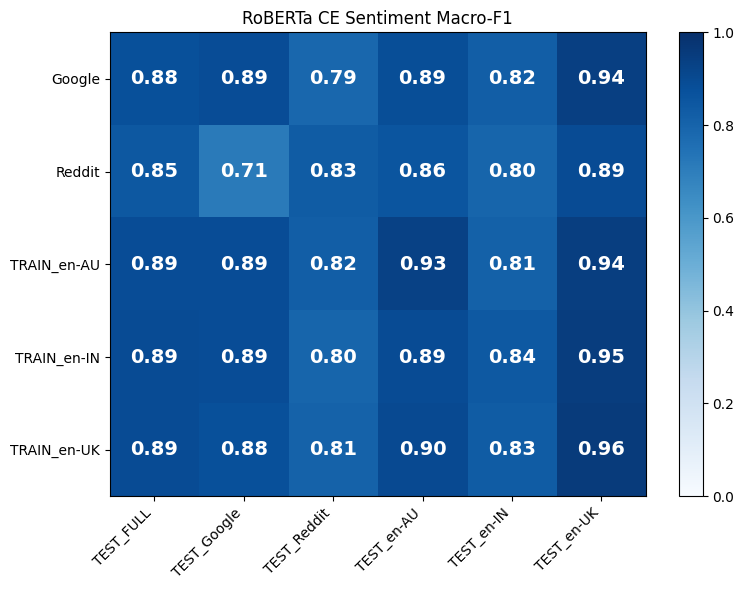

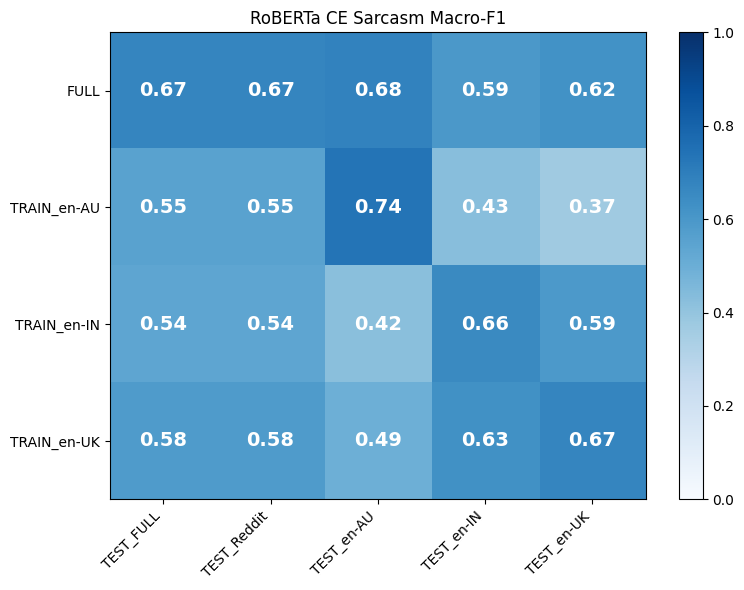

In [ ]:
def heatmap_macro_f1(df: pd.DataFrame, task: str, title: str, out_png: Path):
    sub = df[df["task"] == task].copy()
    if sub.empty:
        print("No rows for", task)
        return
    pivot = sub.pivot_table(index="train_setting", columns="test_setting", values="macro_f1", aggfunc="mean")
    plt.figure(figsize=(8, 6))
    plt.imshow(pivot.values, aspect="auto", cmap="Blues", vmin=0, vmax=1)

    # Add text annotations
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            val = pivot.values[i, j]
            if not np.isnan(val):
                color = "white"
                plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=color, fontsize=14, weight="bold")

    plt.xticks(range(pivot.shape[1]), pivot.columns, rotation=45, ha="right")
    plt.yticks(range(pivot.shape[0]), pivot.index)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.show()

heatmap_macro_f1(metrics_all, "sentiment", "RoBERTa CE Sentiment Macro-F1", FIG_DIR/"heat_sentiment_ce.png")
heatmap_macro_f1(metrics_all, "sarcasm",   "RoBERTa CE Sarcasm Macro-F1",   FIG_DIR/"heat_sarcasm_ce.png")

### **Step 15 — Visualization (Bar Charts)**
*   **Purpose:** Generate bar charts summarizing performance by evaluation type and variety.
*   **Main Inputs:** `metrics_all` DataFrame.
*   **Main Outputs:** Saved PNG bar charts in `FIG_DIR`.

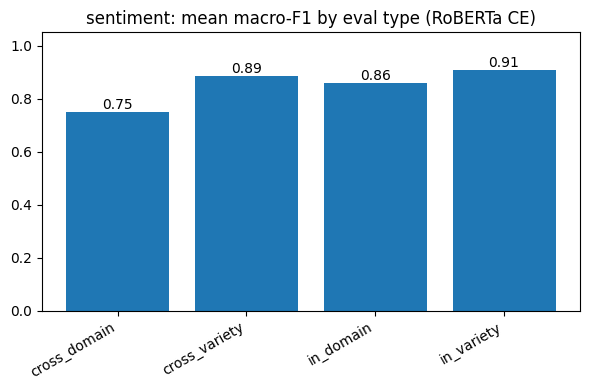

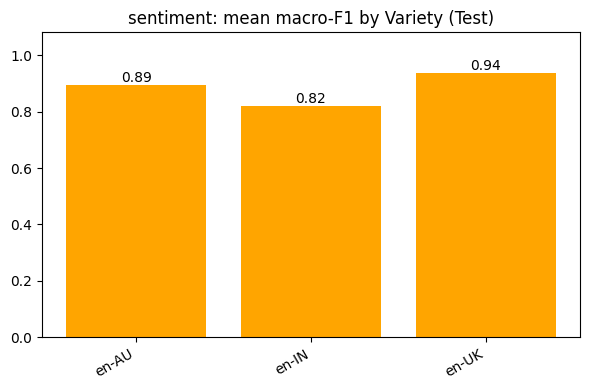

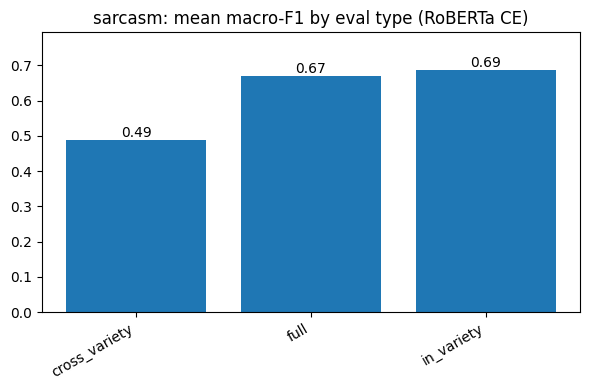

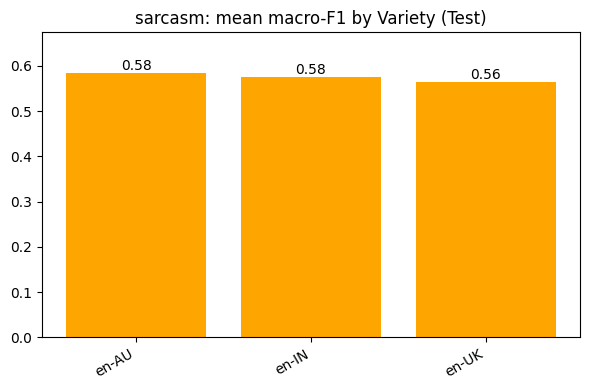

In [ ]:
def add_domain_flag(df):
    df = df.copy()
    def flag(row):
        tr = str(row["train_setting"])
        te = str(row["test_setting"])
        # domain
        if tr in ["Google","Reddit"] and te == f"TEST_{tr}":
            return "in_domain"
        if tr in ["Google","Reddit"] and te.startswith("TEST_") and te in ["TEST_Google","TEST_Reddit"] and te != f"TEST_{tr}":
            return "cross_domain"
        # variety
        if tr.startswith("TRAIN_") and te == ("TEST_" + tr.replace("TRAIN_","")):
            return "in_variety"
        if tr.startswith("TRAIN_") and te.startswith("TEST_en-") and te != ("TEST_" + tr.replace("TRAIN_","")):
            return "cross_variety"
        # full
        if tr == "FULL" and te == "TEST_FULL":
            return "full"
        return "other"
    df["eval_type"] = df.apply(flag, axis=1)
    return df

m2 = add_domain_flag(metrics_all)
sub = m2[m2["eval_type"].isin(["in_domain","cross_domain","in_variety","cross_variety","full"])].copy()

def plot_bar_with_values(x, y, title, filename, color=None):
    plt.figure(figsize=(6,4))
    bars = plt.bar(x, y, color=color)
    plt.title(title)
    plt.xticks(rotation=30, ha="right")

    # Add some headroom for labels
    y_min, y_max = plt.ylim()
    plt.ylim(y_min, y_max * 1.1)

    # Add values
    for rect in bars:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.show()

for task in ["sentiment","sarcasm"]:
    # 1. Existing Eval Type Chart
    d = sub[sub["task"]==task].copy()
    if not d.empty:
        grp = d.groupby("eval_type")["macro_f1"].mean().reset_index()
        plot_bar_with_values(grp["eval_type"], grp["macro_f1"],
                             f"{task}: mean macro-F1 by eval type (RoBERTa CE)",
                             FIG_DIR/f"bar_{task}_evaltype_ce.png")

    # 2. New Per-Variety Chart (Test Performance)
    # Filter for national varieties (e.g. TEST_en-AU, TEST_en-IN...)
    d_var = m2[(m2["task"]==task) & (m2["test_setting"].str.startswith("TEST_en-"))].copy()
    if not d_var.empty:
        d_var["variety"] = d_var["test_setting"].str.replace("TEST_", "")
        grp_var = d_var.groupby("variety")["macro_f1"].mean().reset_index()
        plot_bar_with_values(grp_var["variety"], grp_var["macro_f1"],
                             f"{task}: mean macro-F1 by Variety (Test)",
                             FIG_DIR/f"bar_{task}_variety_ce.png",
                             color="orange")

### **Step 16 — Error Analysis**
*   **Purpose:** Extract and save top high-confidence incorrect predictions.
*   **Main Inputs:** `preds_all` DataFrame.
*   **Main Outputs:** `error_analysis_*.csv` files.

In [ ]:
# This produces examples you can cite in report even before extensions.
def top_mistakes(preds_all: pd.DataFrame, task: str, test_setting: str, k=15):
    df = preds_all[(preds_all["task"]==task) & (preds_all["test_setting"]==test_setting)].copy()
    if df.empty:
        return pd.DataFrame()
    df["wrong"] = (df["label"] != df["pred"]).astype(int)
    # "high confidence wrong": predicted prob far from 0.5
    df["conf"] = (df["prob1"] - 0.5).abs()
    out = df[df["wrong"]==1].sort_values("conf", ascending=False).head(k)
    return out[["text","label","pred","prob1","variety_name","source_name","train_setting","test_setting"]].copy()

ea_sent = top_mistakes(preds_all, "sentiment", "TEST_FULL", k=15)
ea_sarc = top_mistakes(preds_all, "sarcasm", "TEST_FULL", k=15)

ea_sent_path = MET_DIR / "error_analysis_sentiment_ce_top15.csv"
ea_sarc_path = MET_DIR / "error_analysis_sarcasm_ce_top15.csv"

ea_sent.to_csv(ea_sent_path, index=False)
ea_sarc.to_csv(ea_sarc_path, index=False)

print("Saved:", ea_sent_path)
print("Saved:", ea_sarc_path)
display(ea_sent.head(15))
display(ea_sarc.head(15))

Saved: /content/drive/MyDrive/DNLP/models/roberta_baseline_ce/metrics/error_analysis_sentiment_ce_top15.csv
Saved: /content/drive/MyDrive/DNLP/models/roberta_baseline_ce/metrics/error_analysis_sarcasm_ce_top15.csv


,text,label,pred,prob1,variety_name,source_name,train_setting,test_setting
621,bro woke up to revenge the out of context use ...,1,0,0.000097,en-IN,Reddit,Google,TEST_FULL
419,Place is good but they are not maintaining it ...,1,0,0.000105,en-IN,Google,Google,TEST_FULL
804,Undeniably hot.,1,0,0.000142,en-IN,Reddit,Google,TEST_FULL
14567,"Ordered first time ever, takeaway delivered wh...",0,1,0.999848,en-AU,Google,TRAIN_en-UK,TEST_FULL
14991,Reseption boy not cooperative Gayatri madam do...,0,1,0.999846,en-IN,Google,TRAIN_en-UK,TEST_FULL
257,"I dropped out of my science degree, so I'm per...",1,0,0.000155,en-AU,Reddit,Google,TEST_FULL
464,It's not Original Tea day. Most of the items d...,1,0,0.000166,en-IN,Google,Google,TEST_FULL
203,At the Woolies I work at I always pack bags un...,1,0,0.000169,en-AU,Reddit,Google,TEST_FULL
14978,The food we ordered for dinner was normal jeer...,0,1,0.999822,en-IN,Google,TRAIN_en-UK,TEST_FULL
14917,Waited for our order for 30 mins but koi baat ...,0,1,0.999816,en-IN,Google,TRAIN_en-UK,TEST_FULL


,text,label,pred,prob1,variety_name,source_name,train_setting,test_setting
18504,Went to ambani and Adanis vault .,1,0,0.000614,en-IN,Reddit,FULL,TEST_FULL
18517,His condition after spending some quality time...,1,0,0.000932,en-IN,Reddit,FULL,TEST_FULL
18670,Due to price fish and chips is now expensive.,1,0,0.000953,en-UK,Reddit,FULL,TEST_FULL
18633,Not to worry. I'm sure Kjo will cast Jahnvi in...,1,0,0.000955,en-IN,Reddit,FULL,TEST_FULL
18684,I think we can all come together and agree tha...,1,0,0.001134,en-UK,Reddit,FULL,TEST_FULL
18297,This whole thread is disturbing.,1,0,0.001545,en-AU,Reddit,FULL,TEST_FULL
18661,"So no more Covid jabs, hmmmm....\nThey found a...",0,1,0.997758,en-UK,Reddit,FULL,TEST_FULL
20506,Due to price fish and chips is now expensive.,1,0,0.002870,en-UK,Reddit,TRAIN_en-AU,TEST_FULL
20411,>The Gupta Brothers owned South African Presid...,0,1,0.996912,en-IN,Reddit,TRAIN_en-AU,TEST_FULL
24169,"So no more Covid jabs, hmmmm....\nThey found a...",0,1,0.996808,en-UK,Reddit,TRAIN_en-UK,TEST_FULL
